In [ ]:
# Import 
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers import BatchNormalization
from keras.regularizers import L1L2
from google.colab import drive
import tensorflow as tf 
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import shuffle

np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 데이터 셋 경로 
DATADIR = '/content/drive/MyDrive/UCI HAR Dataset/'
# 사용한 특징 
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
    ]


## 파일 Load 및 사용할 수 있도록 변환하는 함수

In [ ]:
# csv file 읽기
def _read_csv(filename):

    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Inertial Signals file load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/drive/MyDrive/UCI HAR Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).to_numpy()
        ) 
    # Sample과 TimeSteps를 조합하여 Signals를 집계
    # 결과 Shape : Train  - 7352 / Test Sample - 2947 / TimeStpes - 128 / Signals - 9
    return np.transpose(signals_data, (1, 2, 0))

# csv파일로 불러온 데이터를 array 형태로 전환
def load_y(subset):
 
    filename = f'/content/drive/MyDrive/UCI HAR Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).to_numpy()

def load_data():

    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test


#Class의 수 Count
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

# Train 및 Test load
X_train, X_test, Y_train, Y_test = load_data()

timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

# 결과
print("Timesteps :", timesteps)
print("Input_dim :",input_dim)
print("train의 길이 :",len(X_train))
print("Test의 길이 :",len(X_test))

Timesteps : 128
Input_dim : 9
train의 길이 : 7352
Test의 길이 : 2947


# Variables

In [ ]:
epochs = 50
batch_size = 16
num_classes = 6
fig_size = (9,7)

# FUNCTIONS

In [ ]:
# Model 
def CREATE_MODEL():
    model = Sequential()
    model.add(LSTM(48, input_shape=(timesteps, input_dim), return_sequences=True,bias_regularizer= L1L2(0.01, 0.01) ))
    model.add(BatchNormalization())
    model.add(Dropout(0.50))
    model.add(LSTM(32))
    model.add(Dropout(0.50))
    model.add(Dense(n_classes, activation='sigmoid'))
    return model

# Model Compile
def COMPILE(model):
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])
    return model;
    
# Model Fit 및 checkpoint 저장
def FIT(model,X,y,i):
    history = model.fit(
    X,
    y,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(f'./model_{i}.h5', save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=1
        )
    ],
    verbose=0
    )
    return history,model

# 학습과정 Plot 보기
def PLOT(history,i):
    epochs_range = range(epochs)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=fig_size)
    plt.plot(epochs_range,train_loss,label="Training Loss")
    plt.plot(epochs_range,val_loss,label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Model {i} - Loss Over Time")
    plt.show()
    
    plt.figure(figsize=fig_size)
    plt.plot(epochs_range,train_acc,label="Training accuracy")
    plt.plot(epochs_range,val_acc,label="Validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title(f"Model {i} - Accuracy")
    plt.show()

# Client 모델 load
def LOAD_MODELS():
    for i in range(1,5):
        model = load_model(f'./model_{i}.h5')
        all_models.append(model)

# 각 모델의 weight를 '평균' 기준으로 계산하여 반환
def APPLY_WEIGHT_FUNCTION(weights):
    avg_model_weights = []
    n_models = len(all_models) #4
    n_layers = len(all_models[0].get_weights())
    for layer in range(n_layers):
        layer_weights = np.array([model.get_weights()[layer] for model in all_models])
        avg_layer_weights = np.average(layer_weights, axis=0, weights=weights)
        avg_model_weights.append(avg_layer_weights)
    return avg_model_weights;

# Client No.1

In [ ]:
# 전체 Train의 개수는 7352개이지만, Client No.1에 1000개로 학습하여 Local model 만들기
X_train_1 = X_train[0:1000] #X_train : 7352 (1838)
Y_train_1 = Y_train[0:1000] #Y_train : 7352

In [ ]:
model_1 =CREATE_MODEL()
model_1.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 128, 48)           11136     
                                                                 
 batch_normalization_5 (Batc  (None, 128, 48)          192       
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 128, 48)           0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                10368     
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                 198       
                                                      

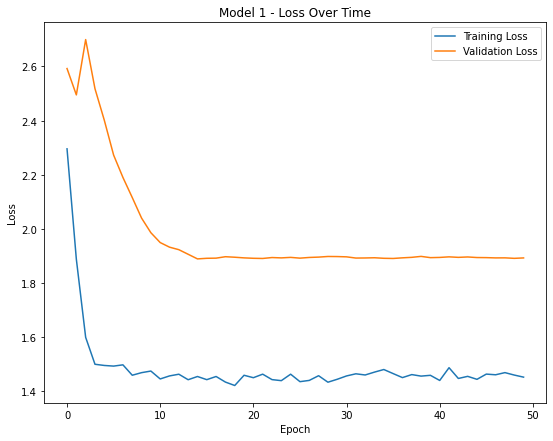

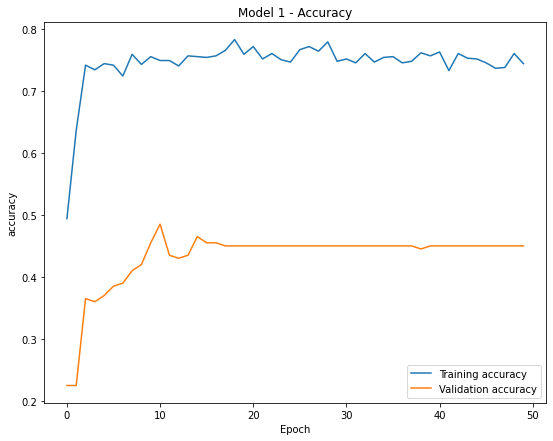

In [ ]:
model_1 = COMPILE(model_1)
history_1,model_1 = FIT(model_1,X_train_1,Y_train_1,1)
PLOT(history_1,1)

# Client no.2

In [ ]:
# 전체 Train의 개수는 7352개이지만, Client No.2에 1000개로 학습하여 Local model 만들기
X_train_2 = X_train[1000:2000]  # [1838:3676] 
Y_train_2 = Y_train[1000:2000]

In [ ]:
model_2 =CREATE_MODEL()
model_2.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 128, 48)           11136     
                                                                 
 batch_normalization_6 (Batc  (None, 128, 48)          192       
 hNormalization)                                                 
                                                                 
 dropout_12 (Dropout)        (None, 128, 48)           0         
                                                                 
 lstm_13 (LSTM)              (None, 32)                10368     
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 6)                 198       
                                                      

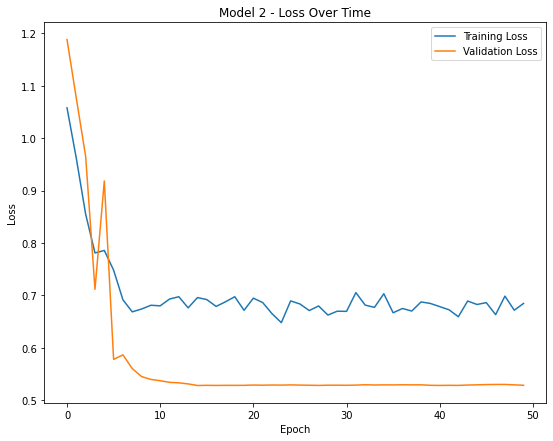

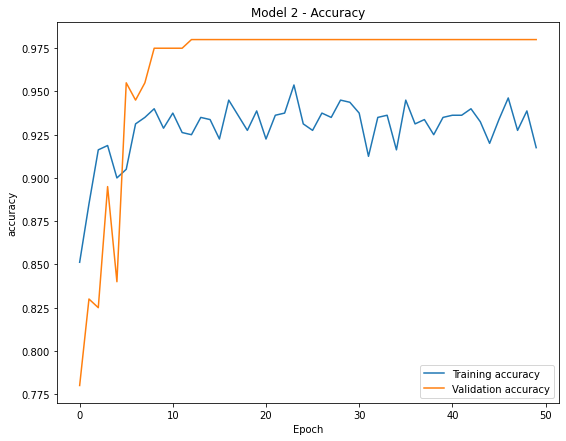

In [ ]:
model_2 = COMPILE(model_2)
history_2,model_2 = FIT(model_2,X_train_2,Y_train_2,2)
PLOT(history_2,2)

# Client No.3

In [ ]:
# 전체 Train의 개수는 7352개이지만, Client No.3에 1000개로 학습하여 Local model 만들기
X_train_3 = X_train[2000:3000] # [3676:5514]
Y_train_3 = Y_train[2000:3000]

In [ ]:
model_3 =CREATE_MODEL()
model_3.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 128, 48)           11136     
                                                                 
 batch_normalization_7 (Batc  (None, 128, 48)          192       
 hNormalization)                                                 
                                                                 
 dropout_14 (Dropout)        (None, 128, 48)           0         
                                                                 
 lstm_15 (LSTM)              (None, 32)                10368     
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 6)                 198       
                                                      

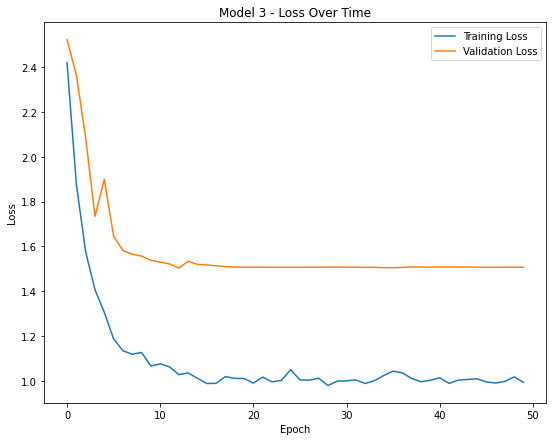

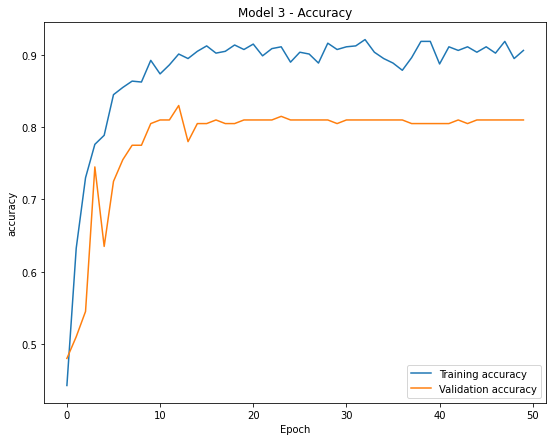

In [ ]:
model_3 = COMPILE(model_3)
history_3,model_3 = FIT(model_3,X_train_3,Y_train_3,3)
PLOT(history_3,3)

# Client No.4

In [ ]:
# 전체 Train의 개수는 7352개이지만, Client No.4에 1000개로 학습하여 Local model 만들기
X_train_4 = X_train[3000:4000] # 5514:
Y_train_4 = Y_train[3000:4000]

In [ ]:
model_4 =CREATE_MODEL()
model_4.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 128, 48)           11136     
                                                                 
 batch_normalization_8 (Batc  (None, 128, 48)          192       
 hNormalization)                                                 
                                                                 
 dropout_16 (Dropout)        (None, 128, 48)           0         
                                                                 
 lstm_17 (LSTM)              (None, 32)                10368     
                                                                 
 dropout_17 (Dropout)        (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 6)                 198       
                                                      

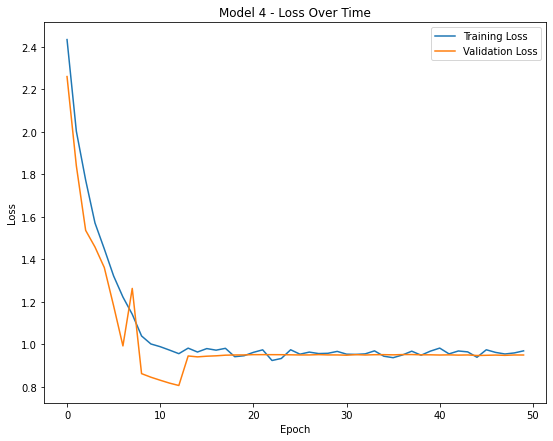

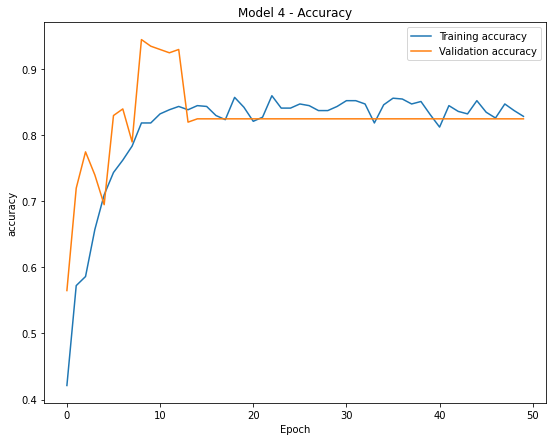

In [ ]:
model_4 = COMPILE(model_4)
history_4,model_4 = FIT(model_4,X_train_4,Y_train_4,4)
PLOT(history_4,4)

# Global Model

In [ ]:
model_100 =CREATE_MODEL()
model_100.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 128, 48)           11136     
                                                                 
 batch_normalization_9 (Batc  (None, 128, 48)          192       
 hNormalization)                                                 
                                                                 
 dropout_18 (Dropout)        (None, 128, 48)           0         
                                                                 
 lstm_19 (LSTM)              (None, 32)                10368     
                                                                 
 dropout_19 (Dropout)        (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 6)                 198       
                                                      

In [ ]:
all_models = [] 
LOAD_MODELS() # Local model 불러오기

In [ ]:
all_models

In [ ]:
weights = [max(history_1.history['accuracy']), max(history_2.history['accuracy']), max(history_3.history['accuracy']), max(history_4.history['accuracy'])] # 각 모델의 지표 중 accuracy가 가장 큰 것 
x = max(weights)        # 제일 큰 weight 값 
idx = weights.index(x)  # 제일 큰 weight값 모델의 index
weights[idx] = 1        # 제일 큰 weight값 모델의 index를 1로 저장
x = min(weights)        # 위와 같은 방식이지만 이번엔 제일 작은 weight 값
idx = weights.index(x)  # 제일 작은 weight 값 모델의 index 
weights[idx] = 0.02     # 제일 작은 weight값 모델의 index를 0.02로 저장
for i in range(3):
    if(weights[i] != 1 and weights[i] != 0.02):   # 가장 큰 weight값도, 제일 작은 weight값도 아니면 0.03으로 저장 
        weights[i] = 0.03
        break
avg_model_weights = APPLY_WEIGHT_FUNCTION(weights)

# Global model 학습

In [ ]:
X_train_100 = X_train[4000:]  
Y_train_100 = Y_train[4000:]

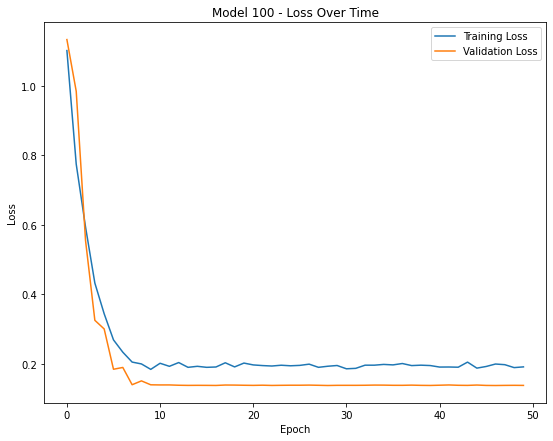

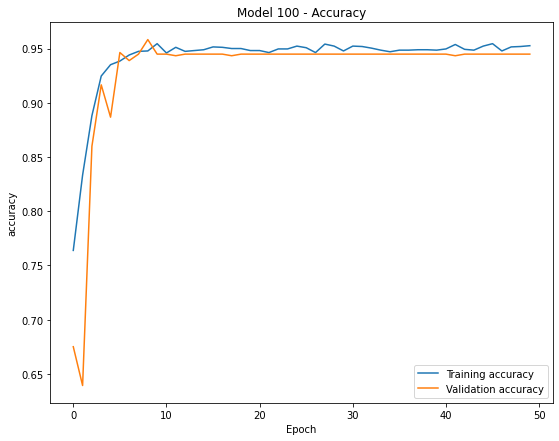

In [ ]:
model_100.set_weights(avg_model_weights) # Global model에 Local model의 weight값 저장
model_100 = COMPILE(model_100) 
history_100,model_100 = FIT(model_100,X_train_100,Y_train_100,100)
PLOT(history_100,100)

# Global Model의 정확도 

In [ ]:
_ , accuracy = model_100.evaluate(X_test,Y_test,verbose=0)
print(f"Global Model Accuracy: {round(accuracy*100,2)}%")

Global Model Accuracy: 88.94%
